#### 一类目标检测算法是基于锚框

- 提出多个被称为锚框的区域（边缘框）
- 预测每个锚框里是否含有关注的物体
- 如果是，预测从这个锚框到真实边缘框的偏移

![1](images/1.jpg)

#### 赋予锚框标号

- 每个锚框是一个训练样本
- 将每个锚框，要么标注成背景，要么关联上一个真实边缘框
- 可能会生成大量的锚框
    - 这个会导致大量的负类样本（也可以让其中一些非最优锚框去匹配最近的一个边缘框）

#### 使用非极大值抑制（NMS）输出

- 每个锚框预测一个边缘框
- NMS可以合并相似的预测
    - 选中是非背景类的最大预测值
    - 去掉所有其他和它 $ IoU $ 值大于 $ \theta $ 的预测（就是把重叠部分超过阈值的框去掉）
    - 重复上述过程直到所有预测要么被选中，要么被去掉

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)

锚框的宽度和高度分别是 $ws\sqrt{r}$ 和 $ hs/ \sqrt{r} $ 。我们只考虑组合：

- w: 宽, h: 高
- s: 锚框占图片的百分比
- r: 锚框的高宽比

$ (s_1, r_1), (s_1, r_2), ..., (s_1, r_m), (s_2, r_1), (s_3, r_1), ..., (s_n, r1) $

In [3]:
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1) # 每个像素会生成（size数+比例数-1）个锚框
    size_tensor = d2l.tensor(sizes, device=device)
    ratio_tensor = d2l.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat(
        (
            size_tensor * torch.sqrt(ratio_tensor[0]),
            sizes[0] * torch.sqrt(ratio_tensor[1:])
        )
    ) * in_height / in_width  # Handle rectangular inputs
    h = torch.cat(
        (
            size_tensor / torch.sqrt(ratio_tensor[0]),
            sizes[0] / torch.sqrt(ratio_tensor[1:])
        )
    )
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack(
        (-w, -h, w, h)
    ).T.repeat(in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack(
        [shift_x, shift_y, shift_x, shift_y],
        dim=1
    ).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)


In [4]:
# 返回的锚框变量Y的形状
img = d2l.plt.imread('../data/catdog.jpg')
h, w = img.shape[:2]
print(h, w)

# 想法：感觉不需要对每个像素都生成锚框（YoloV5好像只有2k个锚框）
# 弹幕说有一个东西叫做：selective search
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [5]:
# 访问以（250， 250）为中心的第一个锚框
boxes = Y.reshape(h, w, 5, 4) # 5：每个像素生成5个锚框（3+3-1）
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In [6]:
# 显示以图像中一个像素为中心的所有锚框
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(d2l.numpy(bbox), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(
                rect.xy[0], 
                rect.xy[1], 
                labels[i], 
                va='center',
                ha='center', 
                fontsize=9, 
                color=text_color,
                bbox=dict(facecolor=color, lw=0)
            )


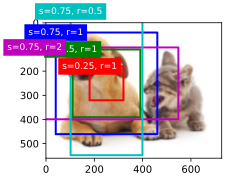

In [7]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(
    fig.axes, 
    boxes[250, 250, :, :] * bbox_scale, 
    ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5']
)

In [8]:
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    def box_area(boxes): return (
        (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    )
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1] # 交集
    union_areas = areas1[:, None] + areas2 - inter_areas # 并集
    return inter_areas / union_areas


In [9]:
# 将真实边界框分配给锚框
# iou_threshold=0.5：如果一个锚框和任何真实框的IoU都小于0.5，就丢弃
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth) # 把所有锚框的IoU全部算出来
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full(
        (num_anchors,), 
        -1, 
        dtype=torch.long,
        device=device
    )
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard # 找到最大的之后，把所在的一行一列删掉
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map


#### 假设一个锚框A被分配了一个真实边界框B。

1. 将锚框A类别标记为与B相同
2. 锚框A的偏移量将根据B和A的中心坐标的相对位置以及这两个框的相对大小进行标记

**注：** 由于数据集中不同框的位置和大小不同，所以要对相对位置和大小应用变换，使其获得分布更均匀且易于拟合的偏移量

<br>

**一种常见变换：**

给定$A$和$B$，中心坐标分别为$ (x_a, y_a) $ 和 $ (x_b, y_b) $ ，
宽度分别为$ w_a, w_b $，高度分别为$ h_a, h_b $，将$A$的偏移量标记为：

$
    (
        \frac{\frac{x_b - x_a}{w_a} - \mu _x}{\sigma _x}, 
        \frac{\frac{y_b - y_a}{h_a} - \mu _y}{\sigma _y},
        \frac{\log \frac{w_b}{w_a} - \mu _w}{\sigma _w},
        \frac{\log \frac{h_b}{h_a} - \mu _h}{\sigma _h}
    ) 
$

其中常量的默认值为：$ \mu _x = \mu _y = \mu _w = \mu _h = 0, \sigma _x = \sigma _y = 0.1, \sigma _w = \sigma _h = 0.2 $。
这种转换在下面的offset_boxes中实现

In [10]:
# 标记类和偏移
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """
        对锚框偏移量的转换
            最简单是四个点作偏移（但是一般不用）
            一般的做法是用中心点和高宽来调整，这样做有助于预测
            （书中有详解）
    """
    # box_corner_to_center: (upper-left, lower-right) to (center, width, height)
    c_anc = d2l.box_corner_to_center(anchors) 
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    # c_assigned_bb：拿出宽和高
    # 在公式中 /0.1 ，代码中实现等价于 *10
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * d2l.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = d2l.concat([offset_xy, offset_wh], axis=1)
    return offset


def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], 
            anchors,
            device
        )
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4
        )
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    """
        bbox_offset: 每一个锚框到真是标注框的offset
        bbox_mask: 如果是0表示是背景，1表示真实标注框
        class_labels: 类标号
    """
    return (bbox_offset, bbox_mask, class_labels)


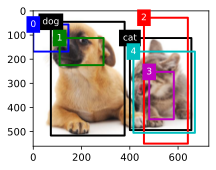

In [11]:
# 在图像中绘制这些地面真实边界框和锚框
ground_truth = torch.tensor([
    [0, 0.1, 0.08, 0.52, 0.92],
    [1, 0.55, 0.2, 0.9, 0.88]
])
anchors = torch.tensor([
    [0, 0.1, 0.2, 0.3], 
    [0.15, 0.2, 0.4, 0.4],
    [0.63, 0.05, 0.88, 0.98], 
    [0.66, 0.45, 0.8, 0.8],
    [0.57, 0.3, 0.92, 0.9]
])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])


In [12]:
# 根据狗和猫的真实边界框，标注这些锚框的分类和偏移量
labels = multibox_target(
    anchors.unsqueeze(dim=0), 
    ground_truth.unsqueeze(dim=0) # 加一个batch维度在最前面
)

labels[2] # 0背景，1，2一个狗一个猫

tensor([[0, 1, 2, 0, 2]])

In [13]:
labels[1] # 每个锚框都是4个数，4个0表示背景，4个1表示有类

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [14]:
# 显示偏移，每四个数一个锚框
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

In [15]:
# 应用逆偏移变换来返回预测的边界框坐标
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = d2l.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = d2l.concat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox


In [16]:
# nms函数：按降序对置信度进行排序并返回索引
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1:
            break
        iou = box_iou(
            boxes[i, :].reshape(-1, 4),
            boxes[B[1:], :].reshape(-1, 4)
        ).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return d2l.tensor(keep, device=boxes.device)


In [17]:
# 将非极大值抑制应用于预测边界框
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat(
            (class_id.unsqueeze(1), conf.unsqueeze(1), predicted_bb), 
            dim=1
        )
        out.append(pred_info)
    return d2l.stack(out)


In [18]:
# 将上述算法应用到一个带有四个锚框的具体示例中
anchors = torch.tensor([
    [0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
    [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]
])
offset_preds = torch.tensor([0] * d2l.size(anchors))
cls_probs = torch.tensor([
    [0] * 4,  # 背景的预测概率
    [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
    [0.1, 0.2, 0.3, 0.9]  # 猫的预测概率
])  


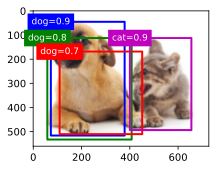

In [19]:
# 不使用nms
fig = d2l.plt.imshow(img)
show_bboxes(
    fig.axes, 
    anchors * bbox_scale,
    ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9']
)


In [20]:
# 调用multibox_detection函数来执行非极大值抑制，阈值设置为0.5
# 返回结果的形状是（批量大小=1，锚框的数量=4，6）
output = multibox_detection(
    cls_probs.unsqueeze(dim=0),
    offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0),
    nms_threshold=0.5)
output


tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

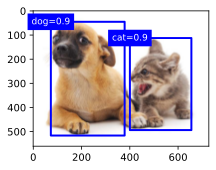

In [21]:
# 使用nms
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)
